In [1]:

import fix_yahoo_finance as yf
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from IPython.display import display
from core.date_utils import next_date

from core.live_data_processor import LiveDataLoader
from core.model import Model

Using TensorFlow backend.


In [2]:


def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()
    
def denormalize_data():
    return 


In [3]:
if __name__ == '__main__':
    #  Setting pyplot fig size
    plt.rcParams['figure.figsize'] = [10, 8]    
    # Download gold price from yahoo finance
    # gld_dataframe = yf.download(tickers="GLD", start="2000-1-1")
    # Display sample dataframe
    # display(gld_dataframe.head(5))
    # display(gld_dataframe.tail(5))

In [4]:

    data = LiveDataLoader(
        filename=os.path.join('data', 'gld.csv'),
        split=0.8,
        cols=['Open', 'Close', 'Volume']
    )
    x, y = data.get_train_data(30, True)
    display_x_train = np.reshape(x, (-1, 3))
    display(pd.DataFrame(display_x_train).head(5))
    display_y_train = np.reshape(y, (-1, 1))
    display(pd.DataFrame(display_y_train).head(5))

,0,1,2
0,0.000000,0.000000,0.000000
1,0.001350,0.009013,0.945144
2,0.007202,0.012844,1.002003
3,0.010128,0.008337,-0.471095
4,0.011254,0.015097,0.018875


,0
0,-0.013054
1,-0.033940
2,-0.043575
3,-0.047460
4,-0.054529


In [5]:
    model = Model()
    model.build_model()
    model.model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
[Model] Model Compiled
Time taken: 0:00:01.194069
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 29, 100)           41600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 29, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 29, 100)           80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_____________________________________

In [6]:
    '''
	# in-memory training
	model.train(
		x,
		y,
		epochs = configs['training']['epochs'],
		batch_size = configs['training']['batch_size'],
		save_dir = configs['model']['save_dir']
	)
	'''
    # out-of memory generative training
    steps_per_epoch = math.ceil(((data.len_train - 30) / 32))
    model.train_generator(
        data_gen=data.generate_train_batch(
            seq_len=30,
            batch_size=32,
            normalise=True
        ),
        epochs=5,
        batch_size=32,
        steps_per_epoch=steps_per_epoch,
        save_dir='saved_models'
    )



[Model] Training Started
[Model] 1 epochs, 32 batch size, 90 batches per epoch
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
90/90 [==============================] - 23s 261ms/step - loss: 0.002319s - loss - E  - ETA: 8s - loss: 0.
[Model] Training Completed. Model saved as saved_models\16042019-181307-e1.h5
Time taken: 0:00:28.118609


[Model] Predicting Point-by-Point...


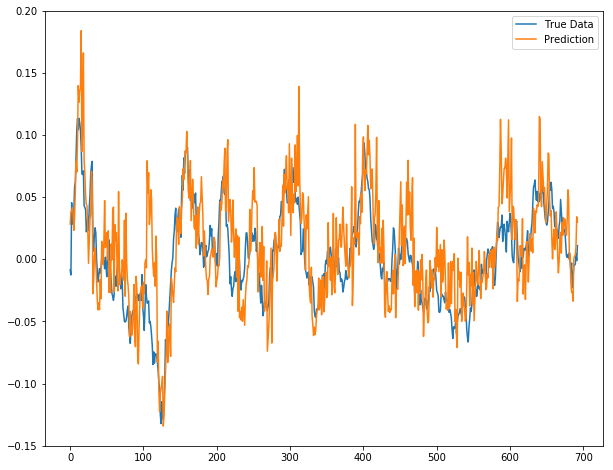

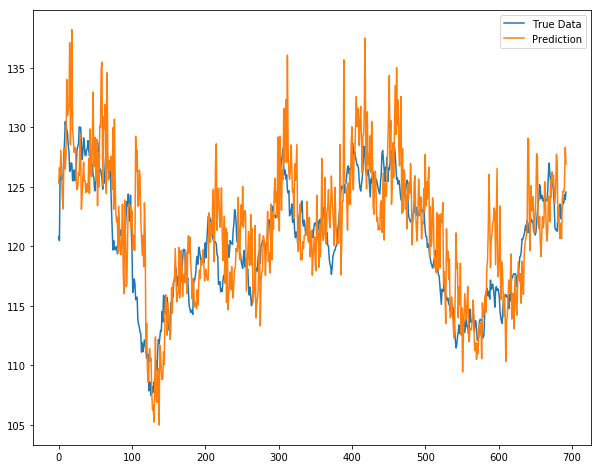

(693,)
(693,)
(693,)


,Date,Prediction,Actual
0,2016-05-11,125.319747,120.830002
1,2016-05-12,126.614873,120.489998
2,2016-05-13,125.912088,126.620003
3,2016-05-16,128.064805,126.440002
4,2016-05-17,125.915471,125.559998
5,2016-05-18,124.060602,125.910004
6,2016-05-19,123.143426,125.949997
7,2016-05-20,126.734164,127.660004
8,2016-05-23,128.246884,128.800003
9,2016-05-24,126.500194,130.500000


[Prediction] Correct 27.42 %
[Prediction] Mean entropy 31.847694
[Prediction] Max deviation 0.316508


In [14]:
    x_test, y_test = data.get_test_data(
    seq_len=30,
    normalise=True)
    
    y_test = y_test[:, -1]
    
    x_test_normal, y_test_normal = data.get_test_data(
                         seq_len=30,
                         normalise=False)
    base_price = x_test_normal[:, -1]
    y_test_normal = y_test_normal[:,-1]
    predictions_p = model.predict_point_by_point(x_test)
    predictions_p_normal = data.denormailise_prediction(30, predictions_p)
    
    plot_results(predictions_p, y_test)
    plot_results(predictions_p_normal, y_test_normal)
    result_panel = pd.DataFrame({'Date': data.get_test_date(30),
                                 'Prediction':predictions_p_normal, 
                                 'Actual':y_test_normal})
    display(result_panel)
    today_input_data = data.get_last_data(29, True)
    today_input_data_normal = data.get_last_data(29, False)
    today_p = model.predict_point_by_point(today_input_data)
    last_date = data.data_test_date[-1]
    today = next_date(last_date)
    print('[Prediction] Base close gold price %f' % float(today_input_data_normal[0, 0, 0]))
    print('[Prediction] Next day %s close gold price normalized %f' % (today, today_p))
    today_p = float(today_input_data_normal[0, 0, 0]) *  (1 + today_p)
    print('[Prediction] Next day %s close gold price %f' % (today, today_p))
    count = 0
    diff=[]
    for i in range(y_test_normal.size):
        prediction = float(predictions_p_normal[i])
        real = float(y_test_normal[i])
        if real != 0 :
            diff.append(abs(prediction / real))
            if abs(1 - abs(prediction / real)) < 0.01 :
                count = count + 1

    diff = np.array(diff)
    # percentage of <5000 difference data in the whole testing data set
    percentage = float(count)/diff.size * 100
    print('[Prediction] Correct %.2f %%' % percentage)
    # display(pd.DataFrame(y_test))
    # display(pd.DataFrame(predictions_p))
    # predicted data that are below 3 difference
    mean_entropy = np.sum(abs(y_test-predictions_p))/len(y_test)

    max_deviation = np.max(abs(y_test-predictions_p))

    deviation = np.array(abs(y_test-predictions_p)).astype(np.float64)
    rmse = np.sqrt(np.sum(predictions_p - y_test)**2)

    print('[Prediction] Mean entropy %f' % mean_entropy)
    print('[Prediction] Max deviation %f' % max_deviation)
    print('[Prediction] Rmse %f' % rmse)


    